## Object-based Mapping for Mobile Robots in Indoor Environments

### Authors: Ajay Ragh, Faris Hajdarpasic, Prasanna Bijja

### Guide: Dr. Tiziano Guadagnino

#### Packages:

Numpy, Pandas, Matplotlib, Pymap2d, Shapely, Imageio, Scipy, PIL

#### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import utils
import imageio as Image
# import glob
# import os

# from scipy.spatial.transform import Rotation as R
# from CMap2D import CMap2D, gridshow
# from scipy.special import softmax
# from shapely.geometry import Point
# from shapely.geometry.polygon import Polygon
# from PIL import Image as image

## Loading poses with localization (tf_echo map -> camera_rgb_frame)

In [2]:
path_input = "../Results/Poses_Results/TF_with_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_with_localization/map_camera_parsed.txt"

utils.parse_pose_from_TF(path_input, path_output)
poses_TF_localization = pd.read_csv(path_output)

### Load the occupancy grid and visualise the poses on the occupancy grid to see the trajectory of robot

Loading map definition from ../Results/Map/rtabmap.yaml
Map definition found. Loading map from ../Results/Map/rtabmap.pgm
(195, 2)
map origin spatial: [-5.53812 -5.47738]
origin ij: [[0 0]]


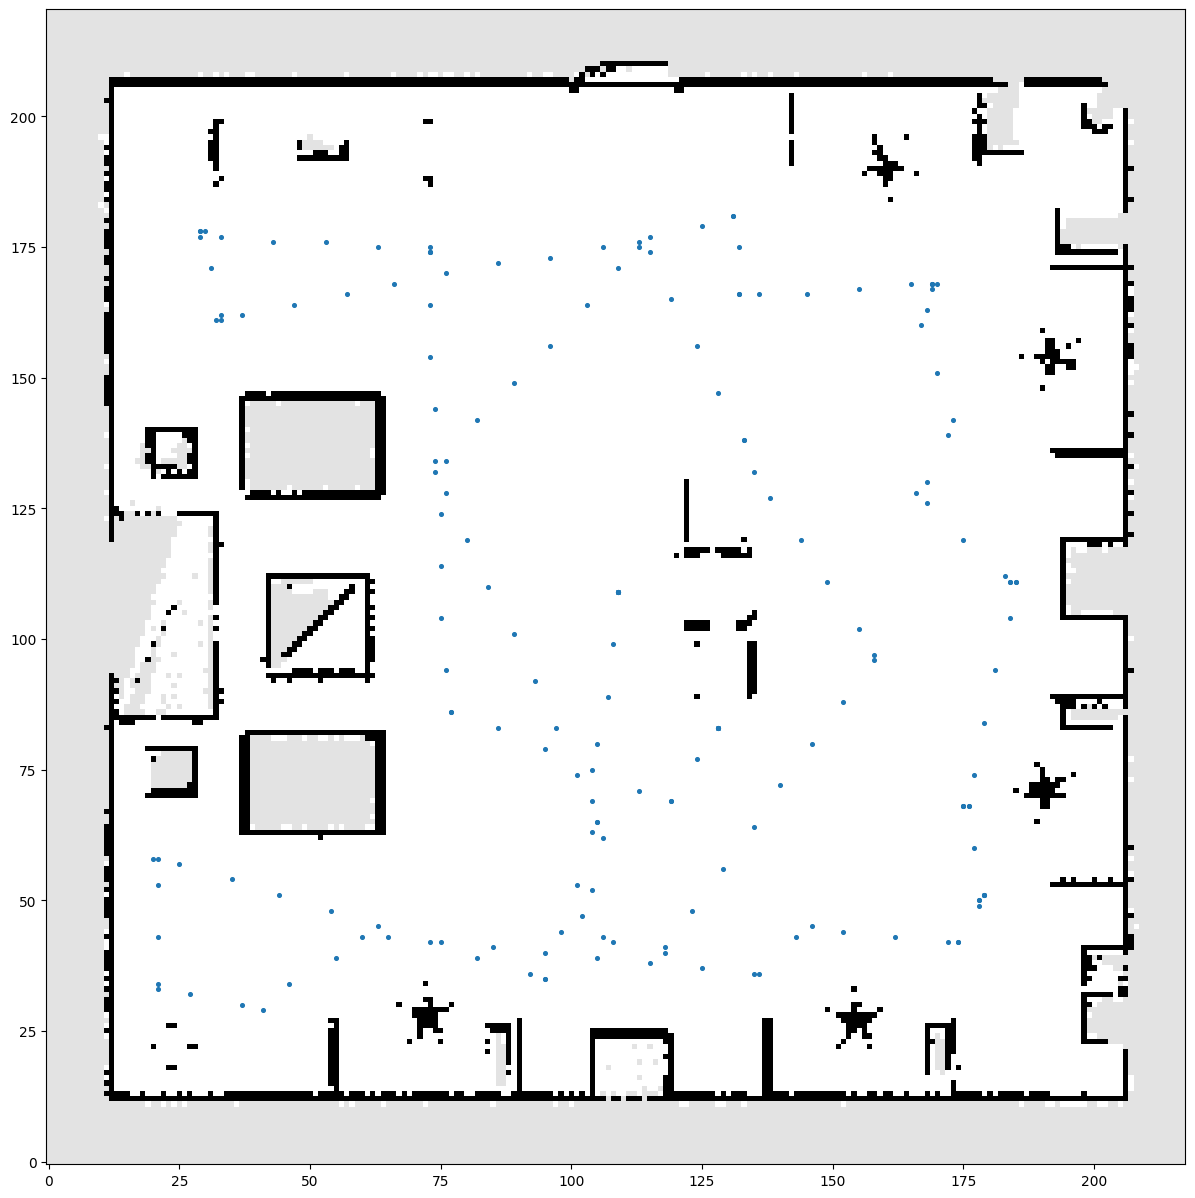

In [3]:
map = CMap2D("../Results/Map", "rtabmap")
occ_grid = map.occupancy()
origin = map.origin_xy()
x = poses_TF_localization['X']
y = poses_TF_localization['Y']
positions = np.zeros((x.shape[0],2))
print(positions.shape)
positions[:,0] = x
positions[:,1] = y
ij_positions = map.xy_to_ij(positions)
plt.figure(figsize=(15,15))
gridshow(occ_grid, cmap='Greys')
plt.scatter(ij_positions[:,0], ij_positions[:,1], s=7, )
print("map origin spatial:", origin)

origin_ij = map.xy_to_ij(origin.reshape(1,-1))
print("origin ij:", origin_ij)


In [4]:
test = Image.v2.imread("../Results/RGBD/segment/8603.168000.jpg")
print(test.shape)

(480, 640, 3)


### Load an rgb image and create the array of pixel coordinates

In [4]:
img = Image.v2.imread("../Results/RGBD/segment/8603.168000.jpg")

pixels = np.zeros((img.shape[1]*img.shape[0], 3), int)
count = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        pixels[count, :] = [i,j,1]
        count +=1

### initialise the values for camera intrinsic matrix

In [5]:
K = np.array([554.3827128226441, 0.0, 320.5, 0.0, 554.3827128226441, 240.5, 0.0, 0.0, 1.0])
# camera intrinsic matrix
K = K.reshape(3,3)
K_inv = np.linalg.inv(K)

### Convert the pixel coordinates into camera rgb frame. 
(Currently the coordinates in this frame will be in canonical frame. we need to bring this into optical frame which is the camera frame)

In [6]:
camera_rgb_frame = (np.matmul(K_inv, pixels.T)).T # dimension [n,3]

### create matrix of depth values for all the images

In [7]:
depth_dir = '../Results/RGBD/depth/*.png'
depth_images = sorted(glob.glob(depth_dir))

z = np.zeros((len(depth_images), pixels.shape[0], 1))
for i in range(z.shape[0]):
    depth = Image.v2.imread(depth_images[i])
    for j in range(z.shape[1]):
        z[i,j,0] = depth[int(pixels[j,1]), int(pixels[j,0])] / 1000

### Create function to make homogenous transformation matrix

In [8]:
def homogenous(roll, pitch, yaw, translation):
    rotation = R.from_euler('xyz', [roll, pitch, yaw])
    rotation = rotation.as_matrix()
    # translation = -np.matmul(rotation, translation)
    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation
    homogeneous_matrix[:3, 3:] = translation

    return homogeneous_matrix

### create matrix of transformation from canonical frame to optical frame

In [9]:
roll = -1.571
pitch = 0.00
yaw = -1.571
translation = np.array([[0.00, 0.00, 0.00]]).T
H_canonical_optical = homogenous(roll, pitch, yaw, translation)

### create matrix of tranformation matrix from camera frame to map frame

In [10]:
H_camera_map = np.zeros((poses_TF_localization.shape[0], 4, 4))
for i in range(poses_TF_localization.shape[0]):
    tx = poses_TF_localization['X'][i]
    ty = poses_TF_localization['Y'][i]
    tz = poses_TF_localization['Z'][i]
    translation = np.array([[tx, ty, tz]]).T
    roll = poses_TF_localization['Roll'][i]
    pitch = poses_TF_localization['Pitch'][i]
    yaw = poses_TF_localization['Yaw'][i]
    H_camera_map[i] = homogenous(roll, pitch, yaw, translation)

#### loading the labels
The labels are of the dimension  [width*height, number of label classes] .

The values are obtained from the last layer of esanet and hence are the probability gradients predicted by esanet for each label class.

In [6]:
import glob
labels_dir = "/home/ajay/work/msc_project/occ_grid_mapping/proj2/gradients/*.npy"
labels = sorted(glob.glob(labels_dir))
test = np.load(labels[2])
test.shape

(307200, 37)

### Previously tested strategies

### Final loop

We first multiply the pixel coordinates with the corresponding depth values associated with the image.

Since the depth values have a limit of 5 meters for now we filter the depth till 4.5 meters.

Then convert these coordinates which are currently in canonical frame into optical frame / camera frame.

Then convert these coordinates from the optical frame into the map frame. 

After the frame conversions we filter the points that are beyond a certain height range (50 cm)

Now we have a dictionary where the keys represent the cell coordinates. for each cell we assign the probability gradients obtained from ESANET by a strategy utilising dependent probabilities. 

Since the probabilities are for the same cell, we consider the old probability as A and new probability as B and considering these two as dependent probabilities. 

Now the probability of A and B is: P(A & B) =  P(A) * P(B). 
So now probability of A given the new probability B is :
P(A|B) = P(A & B) / P(B)

In [17]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = True
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    """The depth sensor has a limit of 5 meters. so in order to account for false segmentation values thet may come
    up due to this cutoff"""
    
    depth_mask = np.squeeze(zi <= 4.95)
    
    #depth filtered camera_rgb_frame pixel coordinates
    camera_rgb_frame_z = np.zeros_like(camera_rgb_frame)
    camera_rgb_frame_z[depth_mask] = camera_rgb_frame[depth_mask] * zi[depth_mask]

    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H_canonical_optical @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (H_camera_map[i] @ camera_frame).T
    map_frame[~depth_mask] = np.array([-1,-1,-1,-1])

    # Filtering out all the points that are outside the range of optical axis height
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 3.0) & (map_frame[:,2] >= 0.6)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]
    
        
    else:
        map_frame_xy = map_frame[:,[0,1]]
        
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    label = np.load(labels[i])
    label = label[map_height_mask]
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"
        
            if (key in occ_labels):
                # multiplying probabilities
                '''since the probabilities are for the same cell, i am considering the old probability as A and new 
                probability as B and  considering these two as dependent probabilities. 
                Now the probability of A and B is: P(A & B) =  P(A) * P(B). 
                So now probability of A given the new probability B is :
                P(A|B) = P(A & B) / P(B)'''
               
                prob_A = occ_labels[key]
                prob_B = label[j]
                prob_A_and_B = [old_label * new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                prob_A_given_B = [prob_a_and_b / prob_b for prob_a_and_b, prob_b in zip(prob_A_and_B, prob_B)]
                occ_labels[key] = prob_A_given_B
 
            else:
                occ_labels[key] = label[j]

### Functions creating set of colors for the labels

In [18]:
import random
random.seed(1)
def get_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        colors.append((r, g, b))
    return colors

def plot_colors(colors, label_names):
    num_colors = len(colors)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlim(0, num_colors)
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    for i, color in enumerate(colors):
        # label = str(i)
        normalized_color = (color[0] / 255, color[1] / 255, color[2] / 255)  # Normalize to range [0, 1]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=normalized_color))
        ax.text(i + 0.5, 0.5, label_names[i], color='white', ha='center', va='center', fontsize=12, rotation=90)

    plt.savefig("sunrgbd_color_labels.png")
    plt.show()

#### SUNRGBD

In [19]:
num_labels = 37
label_names = ['wall',
  'floor',
  'cabinet',
  'bed',
  'chair',
  'sofa',
  'table',
  'door',
  'window',
  'bookshelf',
  'picture',
  'counter',
  'blinds',
  'desk',
  'shelves',
  'curtain',
  'dresser',
  'pillow',
  'mirror',
  'floor_mat',
  'clothes',
  'ceiling',
  'books',
  'fridge',
  'tv',
  'paper',
  'towel',
  'shower_curtain',
  'box',
  'whiteboard',
  'person',
  'night_stand',
  'toilet',
  'sink',
  'lamp',
  'bathtub',
  'bag']
unique_colors = get_random_colors(num_labels)

### Assigning label to occupancy grid based on the highest probability

In [20]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            values = softmax(values)
            label_id = np.argmax(values)
            occ_grid_colorized[i,j] = unique_colors[label_id]

### Plotting the colorized occupancy grid

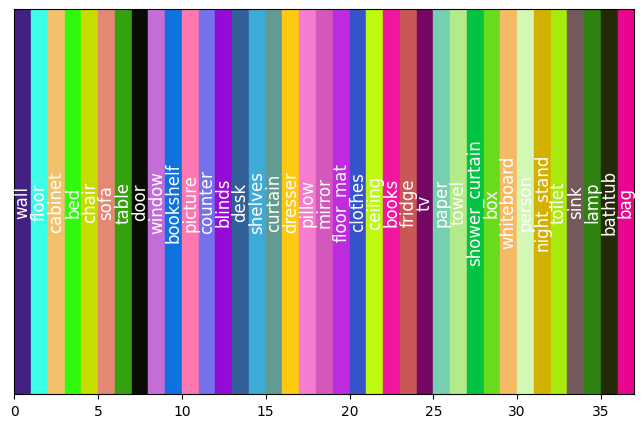

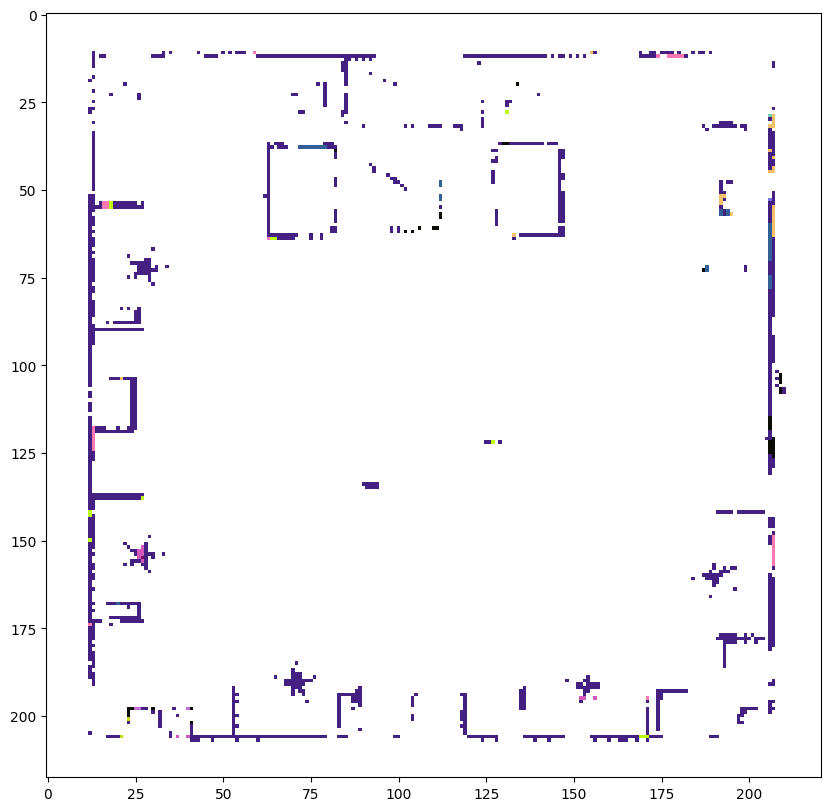

In [21]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)

### Create new occupancy grid for creating polygon maps

In [17]:
occ_grid_new = np.zeros((occ_grid_colorized.shape[0], occ_grid_colorized.shape[1]))
mask = occ_grid_colorized[:,:,:] == [255,255,255]
mask = mask[:,:,0]
occ_grid_new[~mask] = 1 

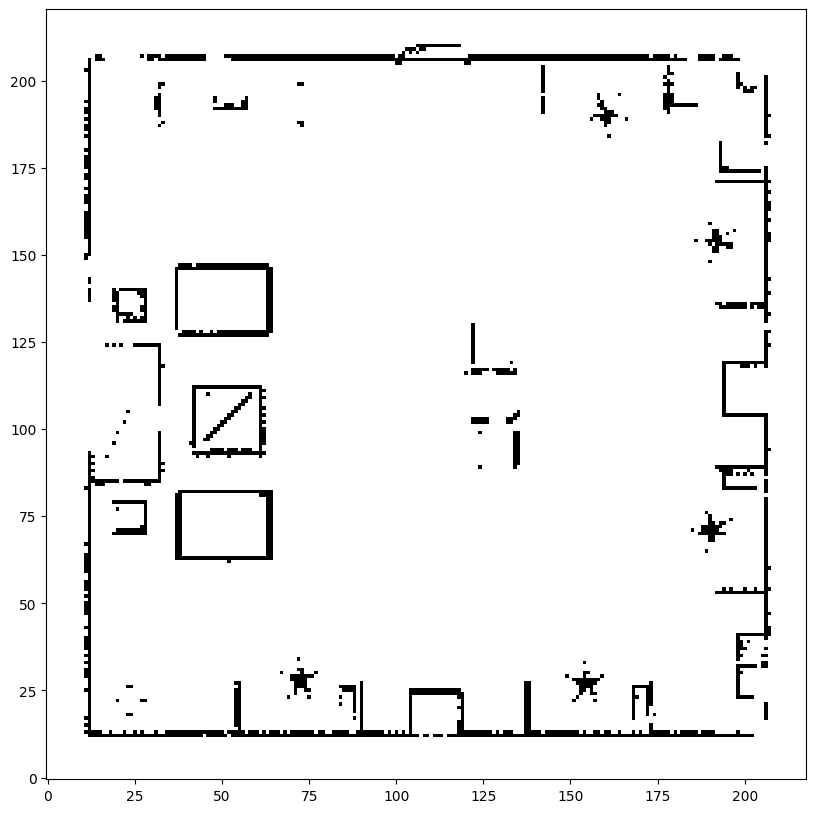

In [18]:
new_map = CMap2D()
new_map.from_array(occ_grid_new, map.origin_xy(), map.resolution())
new_occ_grid = new_map.occupancy()
plt.figure(figsize=(10,10))
gridshow(new_occ_grid)

### Viewing the polygon contours in the new occupancy grid

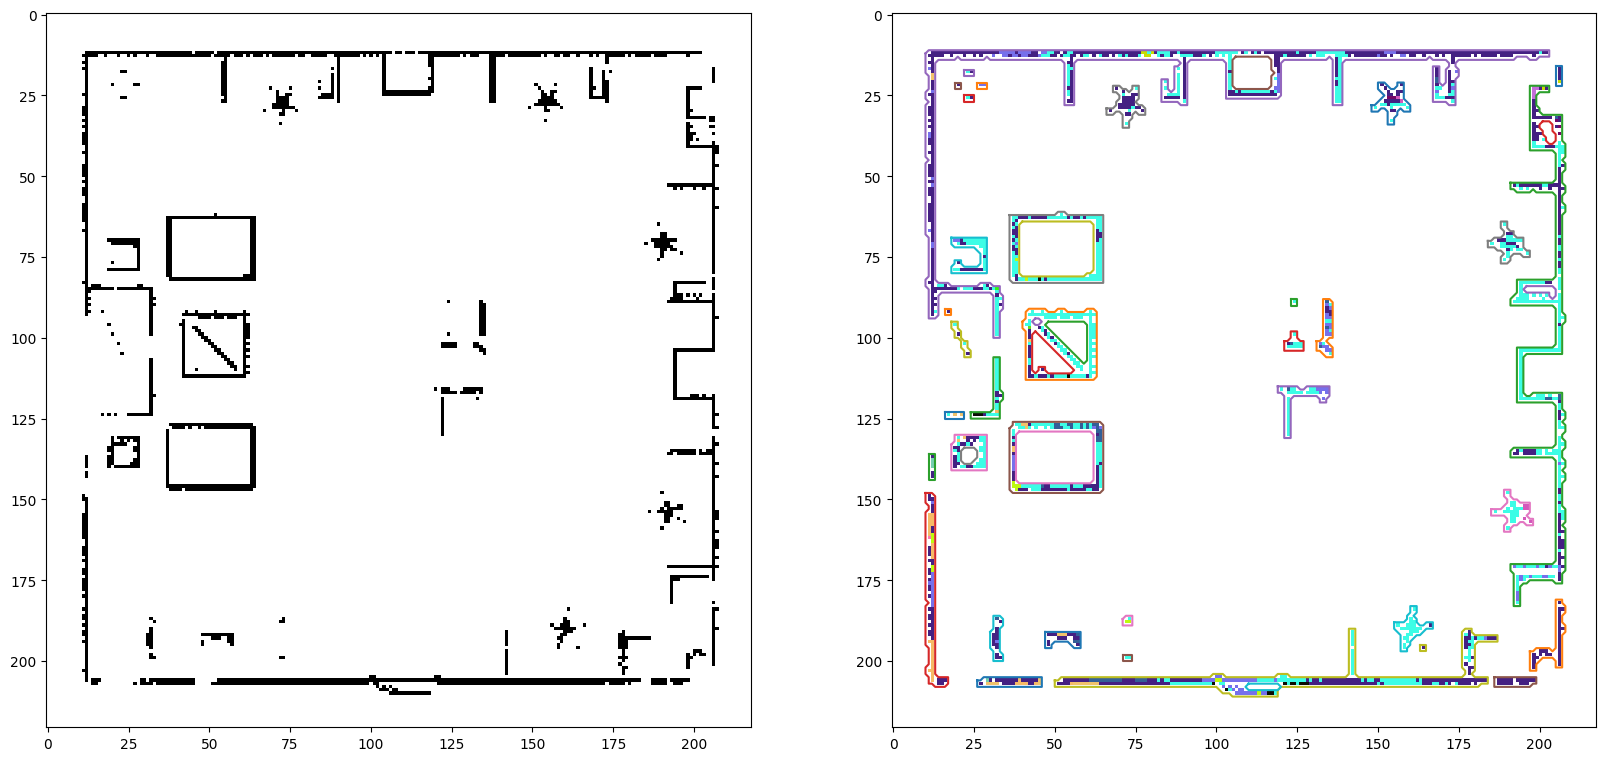

In [19]:
contours = new_map.as_closed_obst_vertices_ij()
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1) 
plt.imshow(np.transpose(occ_grid_new, (1,0)), cmap='Greys')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(occ_grid_colorized, (1,0,2)))

polygons = []
for c in contours:
    poly = Polygon(c)
    polygons.append(poly)
    plt.plot(*poly.exterior.xy)

### labels based on polygon

created a new dictionary to save all the labels for a given polygon (contour of occupancies)

In [20]:
occ_grid_poly_colorized = np.ones_like(occ_grid_colorized) *255
occ_labels_in_poly = {}

for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                
                if (point.within(polygon)):
                    if key in occ_labels_in_poly:
                        occ_labels_in_poly[key] = np.vstack((occ_labels_in_poly[key],occ_labels[keyij]))
                    else:
                        occ_labels_in_poly[key] = np.array(occ_labels[keyij]).reshape([1,-1])

### Assigning global label for a given polygon
Assuming that a polygon in occupancy grid will represent a single object

### Method
Using the method of dependent probabilities for a given polygon, similar to the strategy used previously to assign probabilities to the cells. 

In [21]:
for key in occ_labels_in_poly:
    print(f'key: {key}')
    values =occ_labels_in_poly[key]
    print(f'number of observations in polygon: {len(values)}')
#     break
#     print(len(values))
    temp_label = []
    value = values[0,:]
    for i in range(1,values.shape[0]):
        prob_A = value
        prob_B = values[i,:]
        prob_A_and_B = [A * B for A,B in zip(prob_A, prob_B)] 
        value = prob_A_and_B / prob_B 
        
    value = softmax(value)    
    poly_label = np.argmax(value)
    print(f'polygon label: {poly_label}')
    occ_labels_in_poly[key] = poly_label

key: 44
number of observations in polygon: 634
polygon label: 0
key: 43
number of observations in polygon: 91
polygon label: 0
key: 42
number of observations in polygon: 6
polygon label: 0
key: 41
number of observations in polygon: 1
polygon label: 0
key: 40
number of observations in polygon: 3
polygon label: 1
key: 39
number of observations in polygon: 38
polygon label: 11
key: 38
number of observations in polygon: 4
polygon label: 1
key: 36
number of observations in polygon: 50
polygon label: 0
key: 35
number of observations in polygon: 1
polygon label: 0
key: 34
number of observations in polygon: 2
polygon label: 1
key: 33
number of observations in polygon: 2
polygon label: 1
key: 32
number of observations in polygon: 26
polygon label: 7
key: 31
number of observations in polygon: 2
polygon label: 11
key: 30
number of observations in polygon: 33
polygon label: 0
key: 29
number of observations in polygon: 16
polygon label: 0
key: 27
number of observations in polygon: 130
polygon label

### Assigning colour to the polygon based on the polygon label

In [22]:
for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                if (point.within(polygon)):
                    occ_grid_poly_colorized[i, j, :] = unique_colors[occ_labels_in_poly[key]]

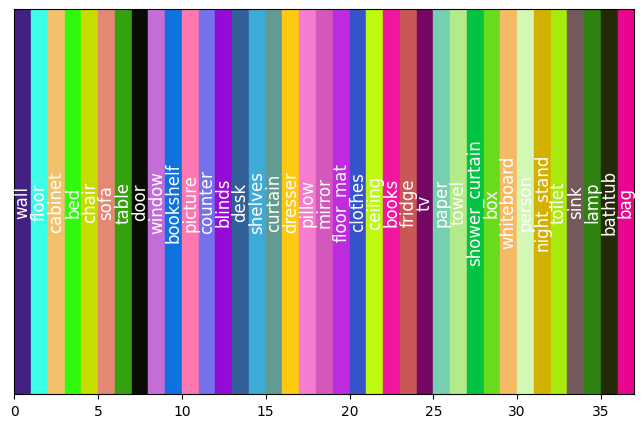

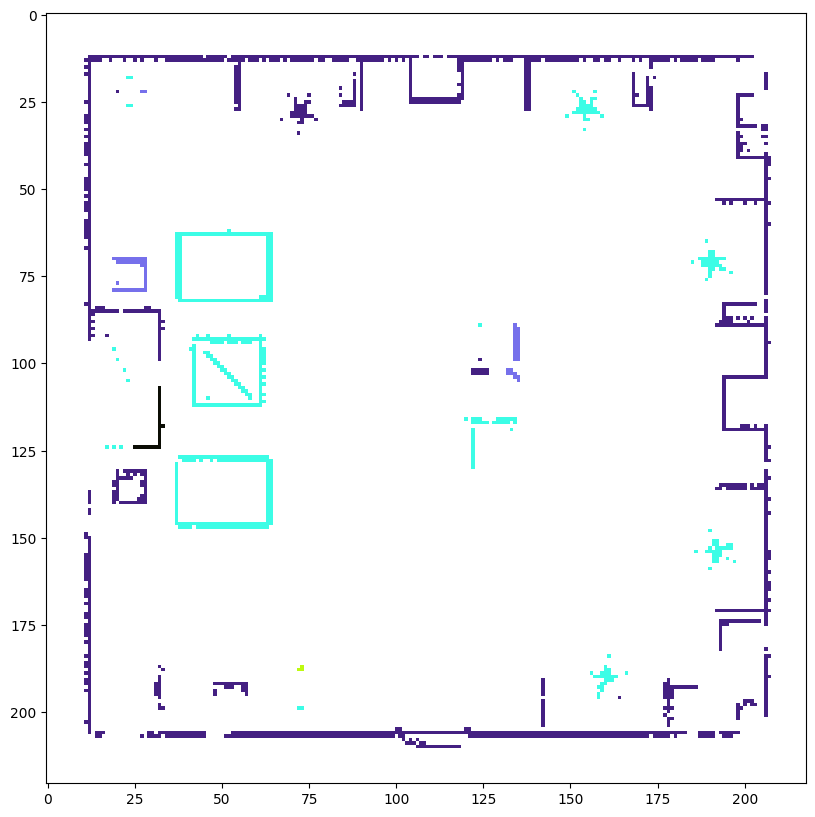

In [23]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(occ_grid_poly_colorized, (1,0,2)))

### Loading annotation and creating masks

In [24]:
# load chairs mask

chairs1 = '../Results/masks/chairs1_mask.png'
chairs = np.array(image.open(chairs1))

bookshelf = '../Results/masks/bookshelf_mask.png'
bookshelf = np.array(image.open(bookshelf))

cabinet = '../Results/masks/cabinets_mask.png'
cabinet = np.array(image.open(cabinet))

door = '../Results/masks/door_mask.png'
door = np.array(image.open(door))

dresser = '../Results/masks/dresser1_mask.png'
dresser = np.array(image.open(dresser))

nightstand = '../Results/masks/nightstand_mask.png'
nightstand = np.array(image.open(nightstand))

small_table = '../Results/masks/small_tables_mask.png'
small_table = np.array(image.open(small_table))

small_table2 = '../Results/masks/small_tables2_mask.png'
small_table2 = np.array(image.open(small_table2))

sofas = '../Results/masks/sofas_mask.png'
sofas = np.array(image.open(sofas))

tables1 = '../Results/masks/tables1_mask.png'
tables1 = np.array(image.open(tables1))

tables2 = '../Results/masks/tables2_mask.png'
tables2 = np.array(image.open(tables2))

tables3 = '../Results/masks/tables3_mask.png'
tables3 = np.array(image.open(tables3))

tables4 = '../Results/masks/tables4_mask.png'
tables4 = np.array(image.open(tables4))

tables5 = '../Results/masks/tables5_mask.png'
tables5 = np.array(image.open(tables5))

tables6 = '../Results/masks/tables6_mask.png'
tables6 = np.array(image.open(tables6))

desks = tables1 + tables2 + tables3 + tables4 + tables5 + tables6
tables = small_table + small_table2

trashcan = '../Results/masks/trashcan_mask.png'
trashcan = np.array(image.open(trashcan))

walls = '../Results/masks/walls_mask.png'
walls = np.array(image.open(walls))

In [25]:
def create_mask(array):
    array_ = array.reshape(-1, array.shape[2])              
    counter, counts = np.unique(array_, axis=0, return_counts=True)
    min_count_idx = np.argmin(counts)
    array_mask = (array[:,:,0] == counter[min_count_idx][0]) 
    return array_mask

chairs_mask = create_mask(chairs)
desks_mask = create_mask(desks)
bookshelf_mask = create_mask(bookshelf)
door_mask = create_mask(door)
cabinet_mask = create_mask(cabinet)
dresser_mask = create_mask(dresser)
nightstand_mask = create_mask(nightstand)
tables_mask = create_mask(tables)
sofas_mask = create_mask(sofas)
trashcan_mask = create_mask(trashcan)
walls_mask = create_mask(walls)

### Assigning label colours for masks

In [26]:
gt = np.ones_like(occ_grid_colorized)*255
gt[:,:,0:3][chairs_mask] = unique_colors[4]
gt[:,:,0:3][desks_mask] = unique_colors[13]
gt[:,:,0:3][bookshelf_mask] = unique_colors[9]
gt[:,:,0:3][door_mask] = unique_colors[7]
gt[:,:,0:3][cabinet_mask] = unique_colors[2]
gt[:,:,0:3][dresser_mask] = unique_colors[16]
gt[:,:,0:3][nightstand_mask] = unique_colors[31]
gt[:,:,0:3][tables_mask] = unique_colors[6]
gt[:,:,0:3][sofas_mask] = unique_colors[5]
gt[:,:,0:3][trashcan_mask] = unique_colors[28]
gt[:,:,0:3][walls_mask] = unique_colors[0]

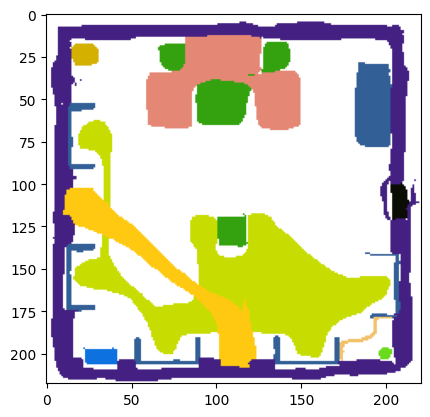

In [27]:
plt.imshow(gt)

### Creating groundtruth from masks

In [28]:
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        if(occ_grid[i,j] != 1.0):
            gt[i,j,:] = 255

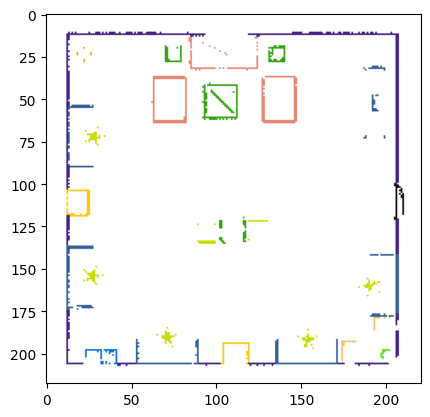

In [29]:
plt.imshow(gt)

### calculate iou and miou

##### non polygon filtered

In [30]:
def calculate_iou(gt_image, test_image, labels):
    global label_names
    iou_sum = 0.0
    num_labels = len(labels)
    iou = []
    for label in range(len(labels)):
        intersection_mask = ((gt_image[:, :, 0] == labels[label][0]) & 
                         (gt_image[:, :, 1] == labels[label][1]) & 
                         (gt_image[:, :, 2] == labels[label][2]) &
                         (test_image[:, :, 0] == labels[label][0]) & 
                         (test_image[:, :, 1] == labels[label][1]) & 
                         (test_image[:, :, 2] == labels[label][2]))
        
        union_mask_gt = ((gt_image[:, :, 0] == labels[label][0]) & 
                   (gt_image[:, :, 1] == labels[label][1]) &
                   (gt_image[:, :, 2] == labels[label][2]))
        
        union_mask_test = ((test_image[:, :, 0] == labels[label][0]) & 
                   (test_image[:, :, 1] == labels[label][1]) &
                   (test_image[:, :, 2] == labels[label][2]))
         
        union_mask = union_mask_gt + union_mask_test
        
        intersection = np.sum(intersection_mask)
        union = np.sum(union_mask)
        
        if union == 0:
            lab_iou = np.nan
            print(f"label: {label_names[label]} \n iou: {lab_iou} \n union: {union} pixels \n intersection: {intersection} pixels")
            iou.append(lab_iou)
        else:
            lab_iou = intersection / union
            print(f"label: {label_names[label]} \n iou: {lab_iou} \n union: {union} pixels \n intersection: {intersection} pixels")
            iou.append(lab_iou)
    
   
    return iou, np.nanmean(iou)


gt_image = gt[:,:,0:3]
test_image = occ_grid_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)

label: wall 
 iou: 0.3330887747615554 
 union: 1363 pixels 
 intersection: 454 pixels
label: floor 
 iou: 0.0 
 union: 931 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 64 pixels 
 intersection: 0 pixels
label: bed 
 iou: 0.0 
 union: 1 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.0 
 union: 197 pixels 
 intersection: 0 pixels
label: sofa 
 iou: 0.0 
 union: 360 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 257 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.05172413793103448 
 union: 58 pixels 
 intersection: 3 pixels
label: window 
 iou: 0.0 
 union: 5 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.0 
 union: 50 pixels 
 intersection: 0 pixels
label: picture 
 iou: 0.0 
 union: 1 pixels 
 intersection: 0 pixels
label: counter 
 iou: 0.0 
 union: 143 pixels 
 intersection: 0 pixels
label: blinds 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.007677543186180422 
 union: 521 pixels 
 intersectio

In [31]:
print(f"label with highest iou: {label_names[np.nanargmax(iou)]}, iou: {iou[np.nanargmax(iou)]}")
print(f'mean iou over all labels: {miou}')

label with highest iou: wall, iou: 0.3330887747615554
mean iou over all labels: 0.01869002170851287


#### polygon filtered

In [32]:
test_image = occ_grid_poly_colorized
iou, miou = calculate_iou(gt_image, test_image, unique_colors)

label: wall 
 iou: 0.40456674473067916 
 union: 1708 pixels 
 intersection: 691 pixels
label: floor 
 iou: 0.0 
 union: 580 pixels 
 intersection: 0 pixels
label: cabinet 
 iou: 0.0 
 union: 35 pixels 
 intersection: 0 pixels
label: bed 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: chair 
 iou: 0.0 
 union: 190 pixels 
 intersection: 0 pixels
label: sofa 
 iou: 0.0 
 union: 360 pixels 
 intersection: 0 pixels
label: table 
 iou: 0.0 
 union: 257 pixels 
 intersection: 0 pixels
label: door 
 iou: 0.0 
 union: 72 pixels 
 intersection: 0 pixels
label: window 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: bookshelf 
 iou: 0.0 
 union: 50 pixels 
 intersection: 0 pixels
label: picture 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: counter 
 iou: 0.0 
 union: 69 pixels 
 intersection: 0 pixels
label: blinds 
 iou: nan 
 union: 0 pixels 
 intersection: 0 pixels
label: desk 
 iou: 0.0 
 union: 472 pixels 
 intersection: 0 pixels
label: shelves 
 iou:

In [33]:
print(f"label with highest iou: {label_names[np.nanargmax(iou)]}, iou: {iou[np.nanargmax(iou)]}")
print(f"miou: {miou}")

label with highest iou: wall, iou: 0.40456674473067916
miou: 0.02889762462361994
